In [1]:
#Import necessary/useful packages
import kwant
import numpy as np
import tinyarray as tiny
from types import SimpleNamespace
import scipy.sparse.linalg as la
from matplotlib import pyplot as plt
import holoviews as hv
hv.extension('matplotlib', logo=False) #BOKEH DOESNT SUPPORT LATEX IN LABELS
from holoviews import opts
hv.output(fig='svg')

C:\ProgramData\Anaconda3\envs\lps\lib\site-packages\kwant\solvers\default.py:18: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  "Performance can be very poor in this case.", RuntimeWarning)


$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
In the Nambu spinor basis
\begin{equation}
\psi^{\dagger}(\mathbf{r}) = \left( c^{\dagger}_{\uparrow}(\mathbf{r}) c^{\dagger}_{\downarrow}(\mathbf{r}) \ 
    c_{\uparrow}(\mathbf{r}) c_{\downarrow}(\mathbf{r}) \right)
\end{equation}
the Hamiltonian from the skyrmion paper <a href=''>insert link[1]</a> reads
\begin{equation}
H(\mathbf{r}) =   \left(  - \frac{1}{2m}\nabla^2 - \mu \right)\tau_z + J \sigma_{\mathbf{r}} \cdot \mathbf{B(r)} + \Delta_0 \tau_x.
\end{equation}
Let's focus only on the magnetic field for now and see if we can get a nice spectrum.
\begin{equation} \tau_z = \sigma_z \otimes I_2 = \begin{pmatrix} I_2 & 0 \\ 0 & -I_2 \end{pmatrix} \to \mu c^{\dagger}_{\uparrow}c_{\uparrow} \end{equation}
\begin{equation} \tau_x = \sigma_x \otimes I_2 =\begin{pmatrix} 0 & I_2 \\ I_2 & 0 \end{pmatrix} \to \Delta c^{\dagger}_{\uparrow}c^{\dagger}_{\uparrow} \end{equation}
\begin{equation} \sigma_z = I_2 \otimes \sigma_z = \begin{pmatrix} \sigma_z & 0 \\ 0 & \sigma_z \end{pmatrix} \to B_z(c^{\dagger}_{\uparrow}c_{\uparrow} -  c^{\dagger}_{\downarrow}c_{\downarrow} ) \end{equation}
\begin{equation} \tau_z \sigma_x = \sigma_z \otimes \sigma_x = \begin{pmatrix} \sigma_x & 0 \\ 0 & -\sigma_x \end{pmatrix}\to \alpha  c^{\dagger}_{\uparrow}c_{\downarrow} \mathrm{\ (spin-flip?)} \end{equation}


In [13]:
# define the Pauli matrices
s_0 = np.identity(2)
s_z = np.array([[1, 0], [0, -1]])
s_x = np.array([[0, 1], [1, 0]])
s_y = np.array([[0, -1j], [1j, 0]])
# pauli = [sx,sy,sz] #pauli = {'x':sx, 'y':sy, 'z':sz} #as dictionary

#define the Pauli matrices 
pauli = SimpleNamespace(s0=np.array([[1., 0.], [0., 1.]]),
                        sx=np.array([[0., 1.], [1., 0.]]),
                        sy=np.array([[0., -1j], [1j, 0.]]),
                        sz=np.array([[1., 0.], [0., -1.]]))

#extend Pauli matrices to particle-hole space (see e.g. BdG 'trick' paper)
pauli.s0s0 = np.kron(pauli.s0, pauli.s0) #I(4)
pauli.s0sx = np.kron(pauli.s0, pauli.sx) #let's extend the sigma's needed for the magnetic exchange
pauli.s0sy = np.kron(pauli.s0, pauli.sy)
pauli.s0sz = np.kron(pauli.s0, pauli.sz) 
pauli.sxs0 = np.kron(pauli.sx, pauli.s0) #for superconducting terms
pauli.sxsx = np.kron(pauli.sx, pauli.sx)
pauli.sxsy = np.kron(pauli.sx, pauli.sy)
pauli.sxsz = np.kron(pauli.sx, pauli.sz)
pauli.sys0 = np.kron(pauli.sy, pauli.s0)
pauli.sysx = np.kron(pauli.sy, pauli.sx)
pauli.sysy = np.kron(pauli.sy, pauli.sy)
pauli.sysz = np.kron(pauli.sy, pauli.sz)
pauli.szs0 = np.kron(pauli.sz, pauli.s0) #for chemical potential
pauli.szsx = np.kron(pauli.sz, pauli.sx) #spin flip or something? don't really know what this does
pauli.szsy = np.kron(pauli.sz, pauli.sy)
pauli.szsz = np.kron(pauli.sz, pauli.sz)


In [14]:
#define a Boolean function to shape your system
r = 10
def disk(position): 
    x,y = position
    return x**2 + y**2 < r**2

def magn_texture(position,p):
    x,y = position
    direction = tiny.array([0,0,1])
    B = p.B0*direction
    return B

def onsite(position,p): #define a function to determine the onsite energy term of the Hamiltonian
    B = magn_texture(position,p) #calculate direction of magnetic field at position (x,y)
    return p.j*(B[0]*pauli.s0sx + B[1]*pauli.s0sy + B[2]*pauli.s0sz) + pauli.szs0*p.mu
    
def hopping(position, p): #define the hopping terms in your system
    return



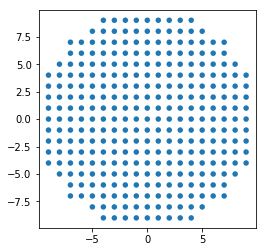

In [8]:
# Build your system, but don't calculate any matrices yet until you're happy with the result, which you can check with kwant.plot(sys).
sys = kwant.Builder() #initialize your system
sqlat = kwant.lattice.square()
sys[sqlat.shape(disk,(0,0))] = onsite #the tuple (0,0) sets the centre of the disk at the origin
# sys[sqlat.neighbors(1)] = 1
# #sys[kwant.HoppingKind((1,1),sqlat,sqlat)]=1
# #sys[kwant.HoppingKind((0,1),sqlat,sqlat)]=0
disk = kwant.plot(sys)

In [12]:
#Finalize the system when you're happy with the structure so that you can solve it and calculate the spectrum
ok = sys.finalized()
p = SimpleNamespace(t=1, mu=-0.1, j=0.02, delta=0.2, B0=0.1) #define your parameters
ham_np = ok.hamiltonian_submatrix(params=p) #returns explicit Hamiltonian as numpy array 
eVal_np,eVec_np = np.linalg.eigh(ham_np)

# For very big systems it is more efficient to calculate the spectrum using sparse matrices
# ham =  ok.hamiltonian_submatrix(sparse=True)
# eVal_sp = la.eigsh(ham,k=ham.shape[0]-2)

AttributeError: 'types.SimpleNamespace' object has no attribute '__getitem__'

In [40]:
# plot energies
hv.Path((np.arange(len(eVal_np)),eVal_np))

:Path   [x,y]

In [8]:
disk.savefig('./fig/disk_hexlat_r={:d}.svg'.format(r))

In [11]:
params.__

<method-wrapper '__getattribute__' of types.SimpleNamespace object at 0x000001BD9E358D38>

In [7]:
import svgutils.compose as sc
from IPython.display import SVG

sc.Figure("30cm", "8cm", 
        sc.Panel(
              sc.SVG("./fig/disk_sqlat_r=10.svg"),
             ),
        sc.Panel(
              sc.SVG('./fig/disk_trialat_r=10.svg'),
             ),
        sc.Panel(
              sc.SVG('./fig/disk_hexlat_r=10.svg'),
             )
        ).tile(3,1)

In [27]:
s_0 = numpy.identity(2)
s_z = numpy.array([[1, 0], [0, −1]])
s_x = numpy.array([[0, 1], [1, 0]])
s_y = numpy.array([[0, −1j], [1j, 0]])
tau_z = tinyarray.array(numpy.kron(s_z, s_0))
tau_x = tinyarray.array(numpy.kron(s_x, s_0))
sigma_z = tinyarray.array(numpy.kron(s_0, s_z))
tau_zsigma_x = tinyarray.array(numpy.kron(s_z, s_x))

array([[[ 0,  0],
        [ 0,  0]],

       [[ 0,  0],
        [ 0,  0]],

       [[ 1,  0],
        [ 0, -1]]])

In [39]:
params = SimpleNamespace(j=1)

In [40]:
origin = onsite((0,0),params)

In [41]:
origin

array([[(1+0j), 0j],
       [0j, (-1+0j)]])

In [42]:
type(origin)

tinyarray.ndarray_complex

In [62]:
def magn_texture(position,p):
    x,y = position
    direction = tiny.array([0,0,1])
    B = p.B0*direction
    return B

In [65]:
params.B0=3
porky = magn_texture((0,0),params)

In [66]:
porky[2]

3